In [2]:
#use extinction environment

import numpy as np
import scipy.signal
from math import log10, floor
from tqdm import tqdm
import shutil
from bisect import bisect_left
from random import sample

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
import astropy.units as u

#for multiprocessing
from joblib import Parallel, delayed

# #to include extinction
# from __future__ import print_function
# from dustmaps.edenhofer2023 import Edenhofer2023Query

#import WD models
import sys
import os
sys.path.append('Software')
import WD_models


MsunCGS=1.989*10**33 #g
RsunCGS=6.955*10**10 #cm
cCGS=2.99792458*10**10 #cm/s
GCGS=6.6743*10**(-8) #cm^3 g^-1 s^-2



# This notebook simulates how to produce an ULDM-like signal by implementing distance-dependent biases and uncertainties

# Import data and bin in distance

In [3]:
#import the VAC catalog measurements with quality cuts
wd_table=pd.read_csv('csv/wd_table.csv')


/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_82206/646736903.py:2: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_table=pd.read_csv('csv/wd_table.csv')


In [4]:
dist_bins=np.arange(0,1050,50)
print(dist_bins)

#get the range and center for each bin
dist_bin_ranges=[]
dist_bin_centers=[]
for i in range(len(dist_bins)-1):
    array=[dist_bins[i],dist_bins[i+1]]
    half=0.5*(dist_bins[i]+dist_bins[i+1])
    dist_bin_ranges.append(array)
    dist_bin_centers.append(half)
dist_bin_nums=np.arange(0,len(dist_bin_ranges))

#save the bin info
np.savez('csv/dist_bins',bins=dist_bins,ranges=dist_bin_ranges,centers=dist_bin_centers,nums=dist_bin_nums)

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000]


In [5]:
def bin_by_dist(table,verbose=False):
    #bin by distance
    dist_bin_ids=[]
    dist_bin_id_ranges=[]
    dist_bin_id_centers=[]
    for i in range(len(table)):
        dist_val=table['r_med_geo'][i]
        for j in range(len(dist_bin_ranges)):
            if dist_bin_ranges[j][0]<=dist_val<dist_bin_ranges[j][1]:
                dist_bin_ids.append(j)
                dist_bin_id_ranges.append(dist_bin_ranges[j])
                dist_bin_id_centers.append(dist_bin_centers[j])
    table['dist_bin_id']=dist_bin_ids
    table['dist_bin_range']=dist_bin_id_ranges
    table['dist_bin_center']=dist_bin_id_centers
    
    if verbose==True:
        for i in range(len(dist_bin_ranges)):
            bin_num=dist_bin_nums[i]
            bin_range=dist_bin_ranges[i]
            tmp=table.query('dist_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' pc, Number of WDs in bin=',len(tmp))
            
    return(table)

In [6]:
binning_table=bin_by_dist(wd_table,verbose=True)

Bin id= 0  Bin range= [0, 50]  pc, Number of WDs in bin= 124
Bin id= 1  Bin range= [50, 100]  pc, Number of WDs in bin= 774
Bin id= 2  Bin range= [100, 150]  pc, Number of WDs in bin= 1501
Bin id= 3  Bin range= [150, 200]  pc, Number of WDs in bin= 1550
Bin id= 4  Bin range= [200, 250]  pc, Number of WDs in bin= 1339
Bin id= 5  Bin range= [250, 300]  pc, Number of WDs in bin= 1137
Bin id= 6  Bin range= [300, 350]  pc, Number of WDs in bin= 997
Bin id= 7  Bin range= [350, 400]  pc, Number of WDs in bin= 846
Bin id= 8  Bin range= [400, 450]  pc, Number of WDs in bin= 621
Bin id= 9  Bin range= [450, 500]  pc, Number of WDs in bin= 436
Bin id= 10  Bin range= [500, 550]  pc, Number of WDs in bin= 343
Bin id= 11  Bin range= [550, 600]  pc, Number of WDs in bin= 197
Bin id= 12  Bin range= [600, 650]  pc, Number of WDs in bin= 145
Bin id= 13  Bin range= [650, 700]  pc, Number of WDs in bin= 63
Bin id= 14  Bin range= [700, 750]  pc, Number of WDs in bin= 52
Bin id= 15  Bin range= [750, 800]  pc

In [7]:
def binned_med_std(table,parameter):
                    
    #calculate the mean/std x for each bin
    bin_nums=dist_bin_nums
    bin_ranges=dist_bin_ranges
    bin_centers=dist_bin_centers
    bin_id_key='dist_bin_id'

    med_xs=[]
    std_xs=[]
    num_obs_per_bin=[]
    for i in range(len(bin_nums)):
        tmp=table.query(bin_id_key+'=='+str(bin_nums[i]))
        if parameter=='e_dist':
            x=tmp['r_hi_geo']-tmp['r_lo_geo']
        else:
            x=tmp[parameter]
        if len(x)>0:
            #calculate mean and std of x
            med_x=np.nanmedian(x)#nanmean(x)
            std_x=np.nanstd(x)
        else: #if bin is empty fill with nan values
            med_x=np.nan
            std_x=np.nan
        #record results
        med_xs.append(med_x)
        std_xs.append(std_x)
        #record how many observations used in averaging
        num_obs=len(tmp)
        num_obs_per_bin.append(num_obs)

    #convert bin ranges to string
    bin_ranges_str=[]
    for i in range(len(bin_ranges)):
        bin_ranges_str.append(str(bin_ranges[i]))
    
    #save parameters
    final_avg_table=pd.DataFrame()
    final_avg_table['bin_id']=bin_nums
    final_avg_table['bin_range']=bin_ranges_str
    final_avg_table['bin_center']=bin_centers
    
    final_avg_table['med']=med_xs
    final_avg_table['std']=std_xs
    final_avg_table['num_obs_per_bin']=num_obs_per_bin
    
    #re-order by bin_id
    final_avg_table=final_avg_table.sort_values(by=['bin_id'])
    
    return(final_avg_table)

In [8]:
#get the median and std for each bin
mass_dist=binned_med_std(binning_table,'mass_rad_theory')
teff_dist=binned_med_std(binning_table,'teff_phot')
l_dist=binned_med_std(binning_table,'l')
b_dist=binned_med_std(binning_table,'b')
e_dist_dist=binned_med_std(binning_table,'e_dist')
e_radius_dist=binned_med_std(binning_table,'e_radius_phot_full')
e_teff_dist=binned_med_std(binning_table,'e_teff_phot_full')
e_logg_dist=binned_med_std(binning_table,'e_logg_prf_coadd_full')


In [8]:
#save these tables
mass_dist.to_csv('csv/mass_dist.csv',index=False)
teff_dist.to_csv('csv/teff_dist.csv',index=False)
l_dist.to_csv('csv/l_dist.csv',index=False)
b_dist.to_csv('csv/b_dist.csv',index=False)
e_dist_dist.to_csv('csv/e_dist_dist.csv',index=False)
e_radius_dist.to_csv('csv/e_radius_dist.csv',index=False)
e_teff_dist.to_csv('csv/e_teff_dist.csv',index=False)
e_logg_dist.to_csv('csv/e_logg_dist.csv',index=False)


# Define functions 

In [9]:
# Import the La Plata WD Models http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html
la_plata_mass=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_mass=la_plata_mass.rename(columns={"Unnamed: 1": "logteff"})
la_plata_mass=la_plata_mass.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_mass))
la_plata_mass.set_index(indices,inplace=True)

la_plata_radius=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_radius=la_plata_radius.rename(columns={"Unnamed: 1": "logteff"})
la_plata_radius=la_plata_radius.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_radius))
la_plata_radius.set_index(indices,inplace=True)

#separate mass and radius info
for col in la_plata_mass.columns.to_list()[1:]:
    masses=[]
    radii=[]
    for i in range(len(la_plata_mass)):
        mass,radius=la_plata_mass[col][i].split(',')
        masses.append(float(mass))
        radii.append(float(radius))
    la_plata_mass[col]=masses
    la_plata_radius[col]=radii

#turn models into interpolation grids

#make grid of mass/radius as function of teff/logg
rows=la_plata_mass['logteff']
teffs = 10**(rows)
columns=la_plata_radius.columns.to_list()[1:]
loggs=[float(i) for i in columns]
mass_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
radius_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        mass_teff_logg_grid[i,j] = la_plata_mass.query('logteff==@logteff')[columns[j]]
        radius_teff_logg_grid[i,j] = la_plata_radius.query('logteff==@logteff')[columns[j]]
    
#get equal-sized arrays
teffs_long=[]
loggs_long=[]
masses_long=[]
radii_long=[]
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        teff=teffs[i]
        logg=loggs[j]
        mass= la_plata_mass.query('logteff==@logteff')[columns[j]].to_list()[0]
        radius= la_plata_radius.query('logteff==@logteff')[columns[j]].to_list()[0]
        teffs_long.append(teff)
        loggs_long.append(logg)
        masses_long.append(mass)
        radii_long.append(radius)   
teffs_long=np.asarray(teffs_long)
loggs_long=np.asarray(loggs_long)
masses_long=np.asarray(masses_long)
radii_long=np.asarray(radii_long)

#define the interpolation functions
mass_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=masses_long, interp_type='linear')     
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
radius_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=radii_long, interp_type='linear')  
radius_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=radii_long, interp_type='linear')  
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
logg_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=loggs_long, interp_type='linear')     


## Make simulated field and WDs

In [10]:
def get_initial_truth_sample(table, sample_size, grid_size, plot=False):
    #this function draws a mass sample from our VAC radius+theory distribution
    #and a teff sample from our measured photometric temperatures
    #using the La Plata models, the radii and loggs of these samples are computed
    
    #place the WDs on a 3D grid centered at the earth of size=grid_size
    #by drawing distances, l, and b from our VAC distrbutions
    #then convert distance, l, and b to cartesian coordinates
    
    draw_size=int(1.5*sample_size)
    
    #draw d,l,b coordinates
    all_measured_distances=table.query('r_med_geo<@grid_size')[['r_med_geo','dist_bin_id']]
    distance_sample_full = all_measured_distances.sample(n = draw_size,replace = True)
    distance_sample=np.array(distance_sample_full['r_med_geo'].to_list())
    distance_bin_sample=np.array(distance_sample_full['dist_bin_id'].to_list())
    #see table above, l and b distributions are not distance-dependent
    all_measured_ls=table['l'] 
    l_sample = np.random.choice(all_measured_ls, size = draw_size, replace = True)
    all_measured_bs=table['b']
    b_sample = np.random.choice(all_measured_bs, size = draw_size, replace = True)
    
    #convert l, b, and distance (which are in galactic coordinates) to a cartesian representation
    coords_cartesian=SkyCoord(l=l_sample*u.deg, 
                              b=b_sample*u.deg, 
                              distance=distance_sample*u.pc,
                              frame='galactic')
    coords_cartesian.representation_type = 'cartesian'
    u_sample=coords_cartesian.u.value
    v_sample=coords_cartesian.v.value
    w_sample=coords_cartesian.w.value
    
    #draw masses and temperatures where depend on distance to WD to account for distance biases
    mass_sample=[]
    teff_sample=[]
    for distance_bin in distance_bin_sample:
        tmp=binning_table.query('dist_bin_id==@distance_bin & mass_rad_theory>0.2 & mass_rad_theory<1.2')
        sample=tmp.sample(n=1,replace=True)
        mass_sample.append(sample['mass_rad_theory'].to_list()[0])
        teff_sample.append(sample['teff_phot'].to_list()[0])
    mass_sample=np.array(mass_sample)
    teff_sample=np.array(teff_sample)
    
    #for given mass and teff samples, get the radii sample
    radius_sample = radius_from_mass_teff(mass_sample, teff_sample)
    #mask any nan samples or WDs with radii>0.029 (these are ELMs)
    out = np.isnan(radius_sample) + (radius_sample > 0.029)
    
    distance_sample = distance_sample[~out]
    l_sample = l_sample[~out]
    b_sample = b_sample[~out]
    u_sample = u_sample[~out]
    v_sample = v_sample[~out]
    w_sample = w_sample[~out]
    mass_sample = mass_sample[~out]
    radius_sample = radius_sample[~out]
    teff_sample = teff_sample[~out]
    
    #for given mass and teff samples, get the logg sample
    logg_sample = logg_from_mass_teff(mass_sample, teff_sample)
    #mask any nan samples or WDs with logg<7 (these are ELMs)
    out = np.isnan(logg_sample) + (logg_sample < 7)
    distance_sample = distance_sample[~out]
    l_sample = l_sample[~out]
    b_sample = b_sample[~out]
    u_sample = u_sample[~out]
    v_sample = v_sample[~out]
    w_sample = w_sample[~out]
    mass_sample = mass_sample[~out]
    radius_sample = radius_sample[~out]
    teff_sample = teff_sample[~out]
    logg_sample = logg_sample[~out]
    
    simulated_wds=pd.DataFrame()
    #record these truth parameters
    simulated_wds['mass_init']=mass_sample
    simulated_wds['teff_init']=teff_sample
    simulated_wds['radius_init']=radius_sample
    simulated_wds['logg_init']=logg_sample
    simulated_wds['distance_init']=distance_sample
    simulated_wds['l_init']=l_sample
    simulated_wds['b_init']=b_sample
    simulated_wds['u_init']=u_sample
    simulated_wds['v_init']=v_sample
    simulated_wds['w_init']=w_sample
    
    #for now, truth parameters=measured parameters
    #so record these values until the measured/truth parameters are updated by other effects
    #in practice, we do not directly measure a mass so do not include that column
    simulated_wds['teff_measured']=teff_sample
    simulated_wds['radius_measured']=radius_sample
    simulated_wds['logg_measured']=logg_sample
    simulated_wds['distance_measured']=distance_sample
    simulated_wds['l_measured']=l_sample
    simulated_wds['b_measured']=b_sample
    simulated_wds['u_measured']=u_sample
    simulated_wds['v_measured']=v_sample
    simulated_wds['w_measured']=w_sample
    
    
    #reduce down to the desired sample size
    simulated_wds= simulated_wds.sample(n=sample_size,replace=False)
    #reset the indices
    indices=np.arange(0,len(simulated_wds))
    simulated_wds.set_index(indices,inplace=True)
    
    if plot==True:
        #plot the samples
        fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3,figsize=(15,23))
        ax1.hist(simulated_wds['mass_init'], density=True, bins='auto', histtype='stepfilled')
        ax1.axvline(x = 0.6, color = 'r')
        ax1.set_xlim([0,1.3])
        ax1.set_xlabel('Mass Sample (Msun)')
        
        ax2.hist(simulated_wds['teff_init'], density=True, bins='auto', histtype='stepfilled')
        ax2.set_xlabel('Teff Sample (K)')
        
        ax3.hist(simulated_wds['radius_init'], density=True, bins='auto', histtype='stepfilled')
        ax3.set_xlabel('Radius Sample\n(Rsun)')
        
        ax4.hist(simulated_wds['logg_init'], density=True, bins='auto', histtype='stepfilled')
        ax4.set_xlabel('Logg Sample\n(dex)')
        
        ax5.set_axis_off()
        ax6.set_axis_off()
        
        ax7.hist(simulated_wds['distance_init'], density=True, bins='auto', histtype='stepfilled')
        ax7.set_xlabel('Distance Sample\n(pc)')
        
        ax8.hist(simulated_wds['l_init'], density=True, bins='auto', histtype='stepfilled')
        ax8.set_xlabel('l Sample\n(deg)')
        
        ax9.hist(simulated_wds['b_init'], density=True, bins='auto', histtype='stepfilled')
        ax9.set_xlabel('b Sample\n(deg)')
        
        ax10.hist(simulated_wds['u_init'], density=True, bins='auto', histtype='stepfilled')
        ax10.set_xlabel('U Sample\n(pc)')
        
        ax11.hist(simulated_wds['v_init'], density=True, bins='auto', histtype='stepfilled')
        ax11.set_xlabel('V Sample\n(pc)')
        
        ax12.hist(simulated_wds['w_init'], density=True, bins='auto', histtype='stepfilled')
        ax12.set_xlabel('W Sample\n(pc)')
        
        plt.subplots_adjust(wspace = 0.3,hspace=0.4)

        plt.show()
        
    return(simulated_wds)

## Calculate Moran's I Statistic at variety of distance cuts

First, add the measured masses to the data frame. The mass is obtained by combining the measured radius with the measured logg (so does not assume any MR relation).

$$M(R,\log{g})=gR^2/G=10^{\log{g}}R^2/G$$
$$\delta M(R,\log{g})=\frac{10^{\log{g}}R}{G}\sqrt{4\delta R^2+(R\ln{10})^2\delta(\log{g})^2}$$


In [11]:
def add_measured_masses(simulated_wds):
    radii=simulated_wds['radius_measured']
    loggs=simulated_wds['logg_measured']
    
    #compute the mass in solar units given measured radius and logg
    masses=[]
    #convert radii from solar units to CGS units
    radii=radii*RsunCGS
    #get the surface gravity
    gs=10**(loggs)
    for i in range(len(radii)):
        M=(gs[i]*(radii[i]**2)/GCGS)/MsunCGS
        masses.append(M)
        
    simulated_wds['mass_measured']=masses
    return(simulated_wds)


In [18]:
def MoransI_contributions(simulated_wds,sample_size,dist_cut_mean,dist_cut_std,dist_cut2,unc_near,unc_far,
                          off_near,off_med,off_far,max_len=100000):
    #this function calculates the contribution to Moran's I from each pair

    #now only inputs are the measured values which might differ from the true values
    ucoords=simulated_wds['u_measured']
    vcoords=simulated_wds['v_measured']
    wcoords=simulated_wds['w_measured']
    mass=simulated_wds['mass_measured']
    radius=simulated_wds['radius_measured']
    teff=simulated_wds['teff_measured']
    distances=simulated_wds['distance_measured']

    #get difference between expected radius from theory+measured mass+measured teff and measured radius with dme variation
    theory_radius = radius_from_mass_teff(mass, teff)
    true_deviation=theory_radius-radius
    
    #define piecewise function that gives % uncertainty on deviation as function of distance
    def deviation_uncertainty(dist):
        dist_cut=np.random.normal(loc=dist_cut_mean, scale=dist_cut_std) 
        if dist<=dist_cut:
            return(unc_near/100.) #unc_near% uncertainty nearby
        else:
            return(unc_far/100.) #unc_far% uncertainty far away

    # define function that gives systematic % offset on deviation as function of distance
    def deviation_offset(dist):
        dist_cut=np.random.normal(loc=dist_cut_mean, scale=dist_cut_std)
        if dist<=dist_cut:
            return(off_near/100.) #off_near% offset nearby
        elif dist>dist_cut and dist<=dist_cut2:
            return(off_med/100.) #off_med% offset at medium distances
        else:
            return(off_far/100.) #off_far% offset far away
        
    #modify the true deviations based on distance-dependent bias and noise
    deviation=[]
    for i in range(len(true_deviation)):
        true_devia=true_deviation[i]
        distance=distances[i]
        std=deviation_uncertainty(distance)*np.abs(true_devia)
        bias=deviation_offset(distance)*np.abs(true_devia)
        #draw random deviation around true deviation
        meas_devia=np.random.normal(loc=true_devia+bias, scale=std) 
        deviation.append(meas_devia)
        
    #set maximum length of resulting i+j DataFrames to break up into pieces
    #otherwise can overwhelm memory when applying to >10,000 WDs
    #don't set maximum length for i dataframe since we have a max of 20,000 WDs anyways
    
    #path to save outputs
    path='csv/nb07_sample_size_'+str(sample_size)+'/'+str(dist_cut_mean)+'_'+str(dist_cut_std)+'_'+str(dist_cut2)+'_'+str(unc_near)+'_'+str(unc_far)+'_'+str(off_near)+'_'+str(off_med)+'_'+str(off_far)+'/tmp/'
    
    #make directory if does not exist
    try:
        os.makedirs(path)
    except:
        pass
    
    #make data frames both for when summing over each WD
    #and for when summing over each WD pair
    contributions_df_isum=pd.DataFrame()
    contributions_df_ijsum=pd.DataFrame()
    
    #compute N
    N=len(ucoords)
        
    #the expected deviation is 0 for dme=0, could also take mean of all deviations
    xbar=0
    
    #compute contributions, assuming weight=1
    #we will implement distance cuts later to calculate values as function of separation
    num_dfs_ijsum=1
    
    Ns=[]
    i_vals_ionly=[]
    denom_MI_conts=[]
    numerator_s3_conts=[]
    denom_s3_conts=[]
    
    i_vals=[]
    j_vals=[]
    separations=[]
    W_conts=[]
    numerator_MI_conts=[]
    s1_conts=[]
    s2_conts=[]
    
    for i in tqdm(range(N)):
        #record N and median absolute deviation
        Ns.append(N)

        #record WD index
        i_vals_ionly.append(i)

        #record Moran's I contributions
        denom_MI_conts.append((deviation[i]-xbar)**2)

        #record Z-score contributions
        numerator_s3_conts.append((deviation[i]-xbar)**4)
        denom_s3_conts.append((deviation[i]-xbar)**2)

    #save output
    contributions_df_isum['N']=Ns
    contributions_df_isum['i']=i_vals_ionly
    contributions_df_isum['denom_MI_cont']=denom_MI_conts
    contributions_df_isum['numerator_s3_cont']=numerator_s3_conts
    contributions_df_isum['denom_s3_cont']=denom_s3_conts
    contributions_df_isum.to_csv(path+'contributions_df_isum.csv',index=False)        
    
    current_len=0
    for i in tqdm(range(N)):
        for j in range(N):
            current_len+=1
            
            #record pair indices
            i_vals.append(i)
            j_vals.append(j)
            
            #record distance between WDs
            u1=ucoords[i]
            v1=vcoords[i]
            w1=wcoords[i]
            u2=ucoords[j]
            v2=vcoords[j]
            w2=wcoords[j]
            separations.append(np.sqrt((u1-u2)**2+(v1-v2)**2+(w1-w2)**2))
            
            #record W contribution
            W_conts.append(1)
            
            #record Moran's I contributions
            numerator_MI_conts.append((deviation[i]-xbar)*(deviation[j]-xbar))
            
            #record Z-score contributions
            s1_conts.append((1+1)**2)
            s2_conts.append((1+1)**2)
            
            #if have multiple of max_len rows then save current list in dataframe and .csv
            if current_len%max_len==0 and current_len!=0:
                #save results
                contributions_df_ijsum['i']=i_vals
                contributions_df_ijsum['j']=j_vals
                contributions_df_ijsum['separation']=separations
                contributions_df_ijsum['W_cont']=W_conts
                contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
                contributions_df_ijsum['s1_cont']=s1_conts
                contributions_df_ijsum['s2_cont']=s2_conts
                contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)
                #record that are starting new DataFrame
                num_dfs_ijsum+=1
                #empty lists and DataFrame
                i_vals=[]
                j_vals=[]
                separations=[]
                W_conts=[]
                numerator_MI_conts=[]
                s1_conts=[]
                s2_conts=[]
                contributions_df_ijsum=pd.DataFrame()
    #whenever finish loop, also save output
    contributions_df_ijsum['i']=i_vals
    contributions_df_ijsum['j']=j_vals
    contributions_df_ijsum['separation']=separations
    contributions_df_ijsum['W_cont']=W_conts
    contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
    contributions_df_ijsum['s1_cont']=s1_conts
    contributions_df_ijsum['s2_cont']=s2_conts
    contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)

    return(path,num_dfs_ijsum,current_len)


In [13]:
def MoransI_calculation(path,num_dfs_ijsum,distance_cuts):
    #this function calculates Moran's I at various distance cuts
    
    Ws=[]
    moransIs=[]
    expectations=[]
    variances=[]
    zscores=[]
    for d_cut in distance_cuts:
        #calculate each parameter by summing over the DataFrames
        
        #sums over individual WDs
        denom_MI=0
        numerator_s3=0
        denom_s3=0
        contributions_df_isum=pd.read_csv(path+'contributions_df_isum.csv')
        denom_MI+=contributions_df_isum['denom_MI_cont'].sum()
        numerator_s3=contributions_df_isum['numerator_s3_cont'].sum()
        denom_s3=contributions_df_isum['denom_s3_cont'].sum()
        
        #sums over WD pairs
        W=0
        s1=0
        s2=0
        numerator_MI=0
        for j in range(num_dfs_ijsum):
            contributions_df_ijsum=pd.read_csv(path+'contributions_df_ijsum_'+str(j+1)+'.csv')
            
            #keep only distances within the cut and drop any rows where i=j, this enforces the weight matrix
            apply_weights_df=contributions_df_ijsum.query('separation<=@d_cut and i!=j')
            
            W+=float(apply_weights_df['W_cont'].sum())
            numerator_MI+=apply_weights_df['numerator_MI_cont'].sum()
            s1+=apply_weights_df['s1_cont'].sum()
            s2+=apply_weights_df['s2_cont'].sum()
        
        
        N=float(contributions_df_isum.iloc[0]['N'])
        
        try:
            #Moran's I
            moransI=(N/W)*(numerator_MI/denom_MI)

            #expectation value
            expectation=-1/(N-1)

            #variance
            s1=(1/2)*s1
            s3=((1/N)*numerator_s3)/(((1/N)*denom_s3)**2)
            s4=(N**2-3*N+3)*s1-(N*s2)+(3*(W**2))
            s5=(N**2-N)*s1-(2*N*s2)+(6*(W**2))
            expect_Isqr=(N*s4-s3*s5)/((N-1)*(N-2)*(N-3)*(W**2))
            var=expect_Isqr-expectation**2

            #Z-score
            zscore=(moransI-expectation)/np.sqrt(var)
        except:
            moransI=np.nan
            expectation=np.nan
            var=np.nan
            zscore=np.nan
        
        #save results
        Ws.append(W)
        moransIs.append(moransI)
        expectations.append(expectation)
        variances.append(var)
        zscores.append(zscore)
        
    return(Ws,moransIs, expectations, variances,zscores)

# Put everything together and investigate the effects of distance dependent noise and bias

In [14]:
def full_simulation(sample_size,grid_size,distances,dist_cut_mean,dist_cut_std,dist_cut2,unc_near,unc_far,
                          off_near,off_med,off_far):
    
    #check if simulation exists
    try:
        npzfile = np.load('csv/nb07_sample_size_'+str(sample_size)+'/'+str(dist_cut_mean)+'_'+str(dist_cut_std)+'_'+str(dist_cut2)+'_'+str(unc_near)+'_'+str(unc_far)+'_'+str(off_near)+'_'+str(off_med)+'_'+str(off_far)+'/output.npz')
    except:
        #get truth sample
        simulated_wds=get_initial_truth_sample(binning_table,sample_size,grid_size)

        #add the measured masses with any desired noise sources
        simulated_wds=add_measured_masses(simulated_wds)

        #get contributions of each WD pair to Moran's I
        path,num_dfs_ijsum,tot_len=MoransI_contributions(simulated_wds,sample_size,dist_cut_mean,dist_cut_std,dist_cut2,unc_near,unc_far,
                                                          off_near,off_med,off_far)

        #calculate Moran's I for range of distances 
        Ws,moransIs, expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

        #make directory if does not exist
        final_path='csv/nb07_sample_size_'+str(sample_size)+'/'+str(dist_cut_mean)+'_'+str(dist_cut_std)+'_'+str(dist_cut2)+'_'+str(unc_near)+'_'+str(unc_far)+'_'+str(off_near)+'_'+str(off_med)+'_'+str(off_far)+'/' 

        try:
            os.makedirs(final_path)
        except:
            pass

        #write the data in a txt file
        np.savez(final_path+'output',Ws=Ws, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  

        #delete the intermediate files
        shutil.rmtree(path)


In [15]:
def get_output(sample_size,dist_cut_mean,dist_cut_std,dist_cut2,unc_near,unc_far,off_near,off_med,off_far,
               nonzero_weight_cut=20,plot=True,plot_real_data=False):
    #read back in measurements
    npzfile = np.load('csv/nb07_sample_size_'+str(sample_size)+'/'+str(dist_cut_mean)+'_'+str(dist_cut_std)+'_'+str(dist_cut2)+'_'+str(unc_near)+'_'+str(unc_far)+'_'+str(off_near)+'_'+str(off_med)+'_'+str(off_far)+'/output.npz')
    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axvline(corr_length,color='green',label='True Correlation\nLength')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.axvline(corr_length,color='green')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.axvline(corr_length,color='green')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
        
        if plot_real_data:
            #plot extinction-corrected data
            file_path='csv/nb06_sample_size_'+str(sample_size)
            npzfile = np.load(file_path+'/data_measurement.npz')
            med_abs_deviations = npzfile['med_abs_deviations']
            Ws = npzfile['Ws']
            final_distances = npzfile['distances']
            moransIs = npzfile['moransIs'] 
            expectations = npzfile['expectations']
            variances = npzfile['variances']
            zscores = npzfile['zscores']

            mult=[]
            for i in range(len(moransIs)):
                mult.append(moransIs[i]*zscores[i])
                
            ax1.plot(final_distances,moransIs,color='black',label='Real Data')
            ax2.plot(final_distances,zscores,color='black')
            ax3.plot(final_distances,mult,color='black')
        
        ax1.legend()
        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,Ws,moransIs,expectations,variances,zscores,mult,index)


# No dark matter simulations for sample_size=10207

In [16]:
sample_size=10207
grid_size=1000
#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                            425,450,475,500,550,600,650,700,750,800,850,900,1000])


0 5 90 1 140 5


100%|█████████████████████████████████████| 10538/10538 [17:29<00:00, 10.04it/s]


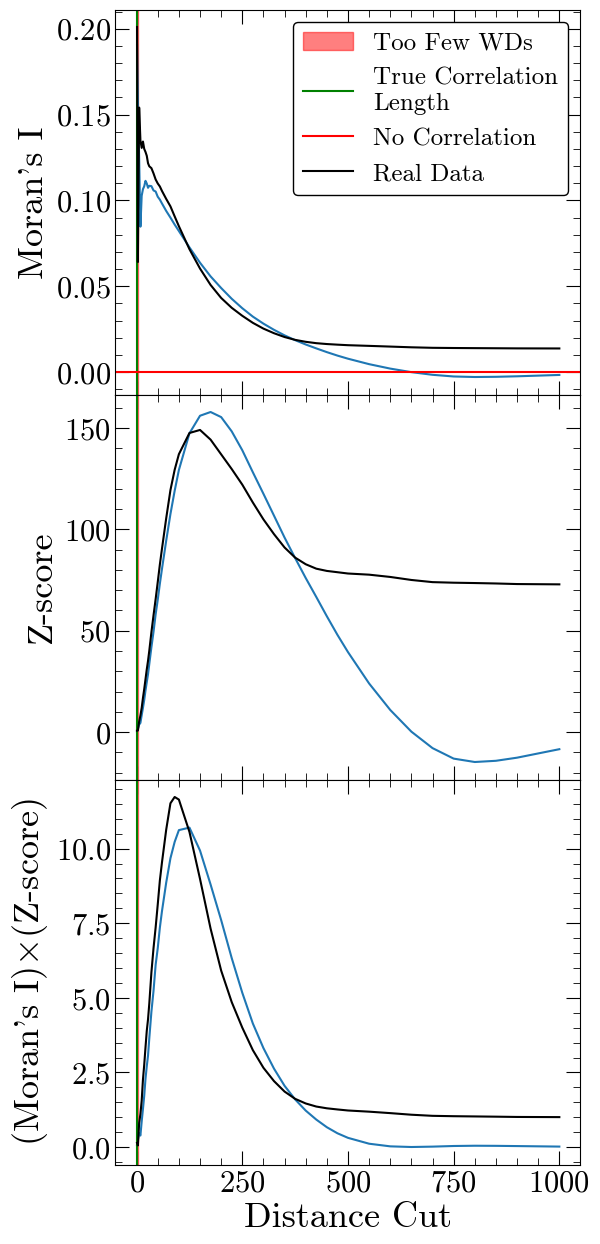

0 5 90 1 140 20


100%|█████████████████████████████████████| 10538/10538 [17:43<00:00,  9.91it/s]


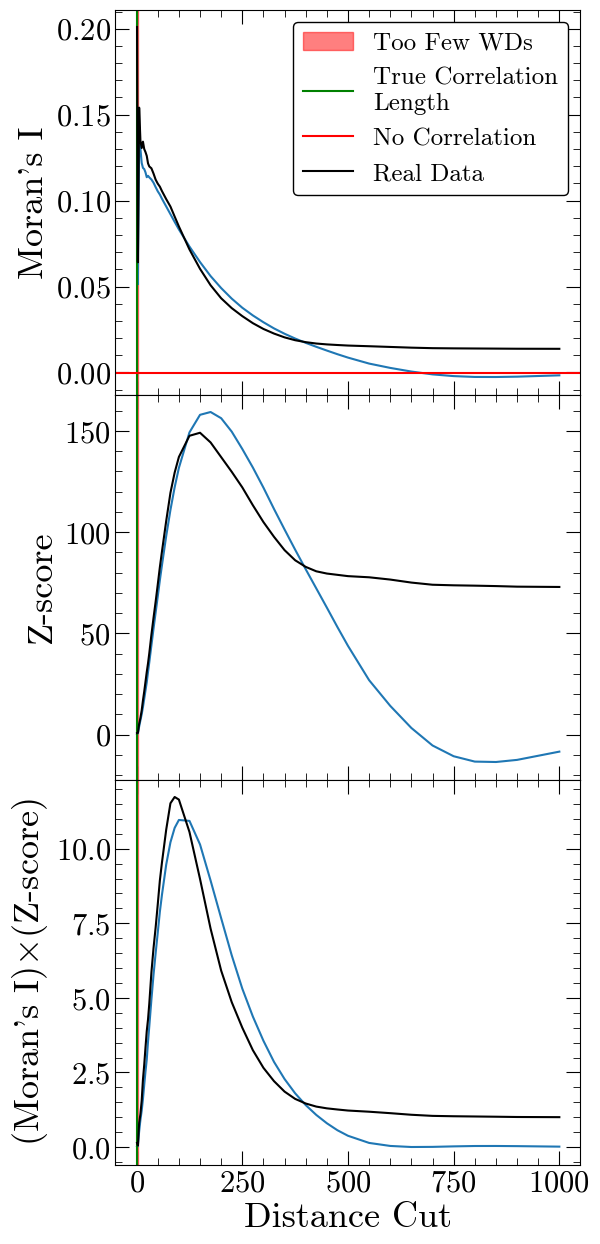

0 5 90 1 160 5


100%|█████████████████████████████████████| 10538/10538 [17:42<00:00,  9.92it/s]


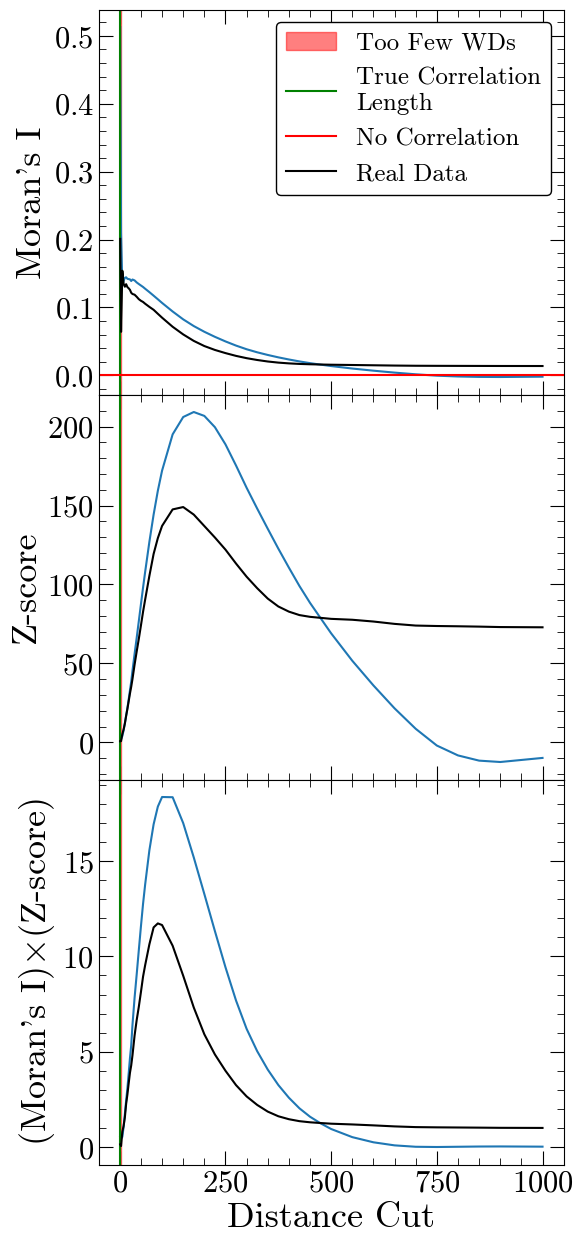

0 5 90 1 160 20


100%|█████████████████████████████████████| 10538/10538 [17:38<00:00,  9.95it/s]


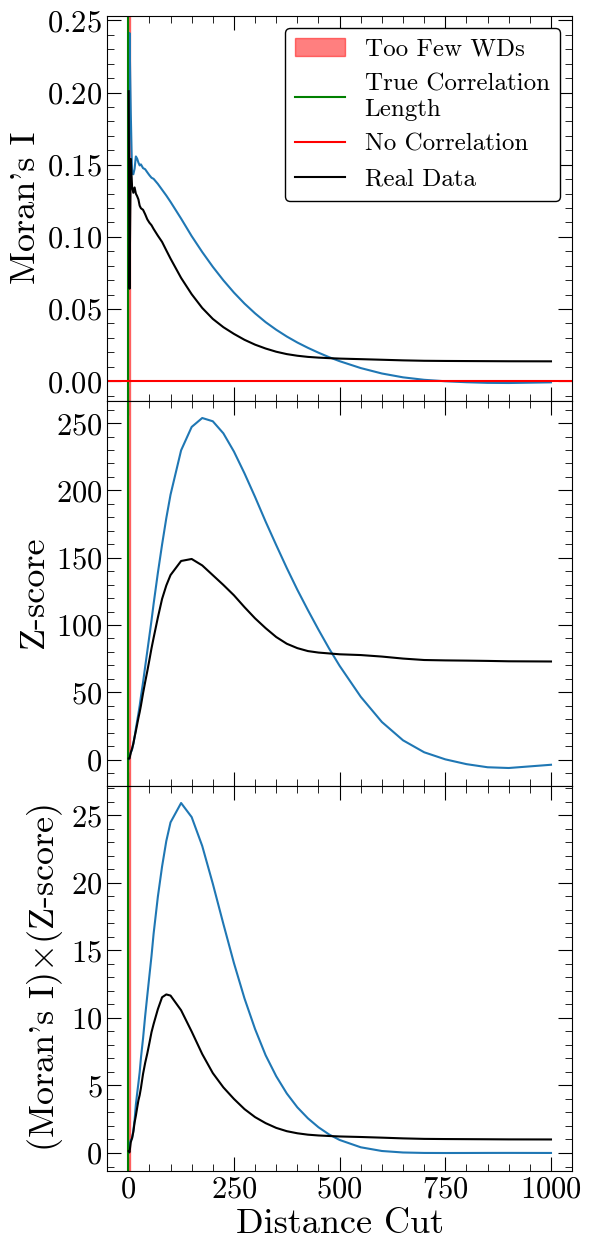

0 5 90 3 140 5


100%|█████████████████████████████████████| 10538/10538 [17:40<00:00,  9.93it/s]


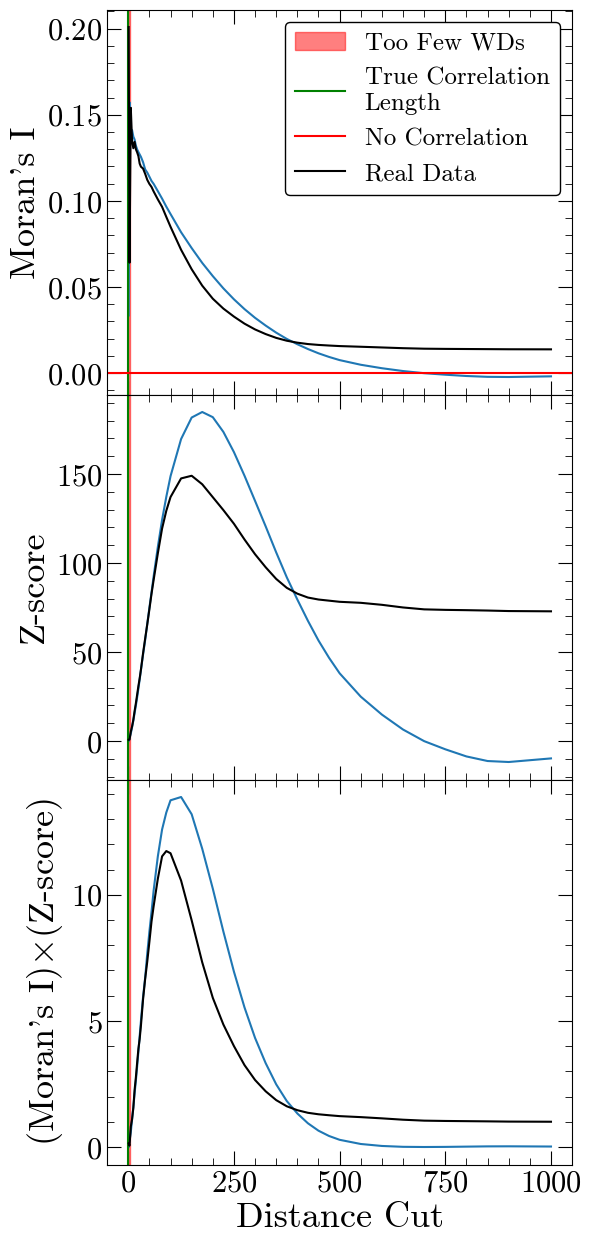

0 5 90 3 140 20


100%|█████████████████████████████████████| 10538/10538 [17:38<00:00,  9.96it/s]


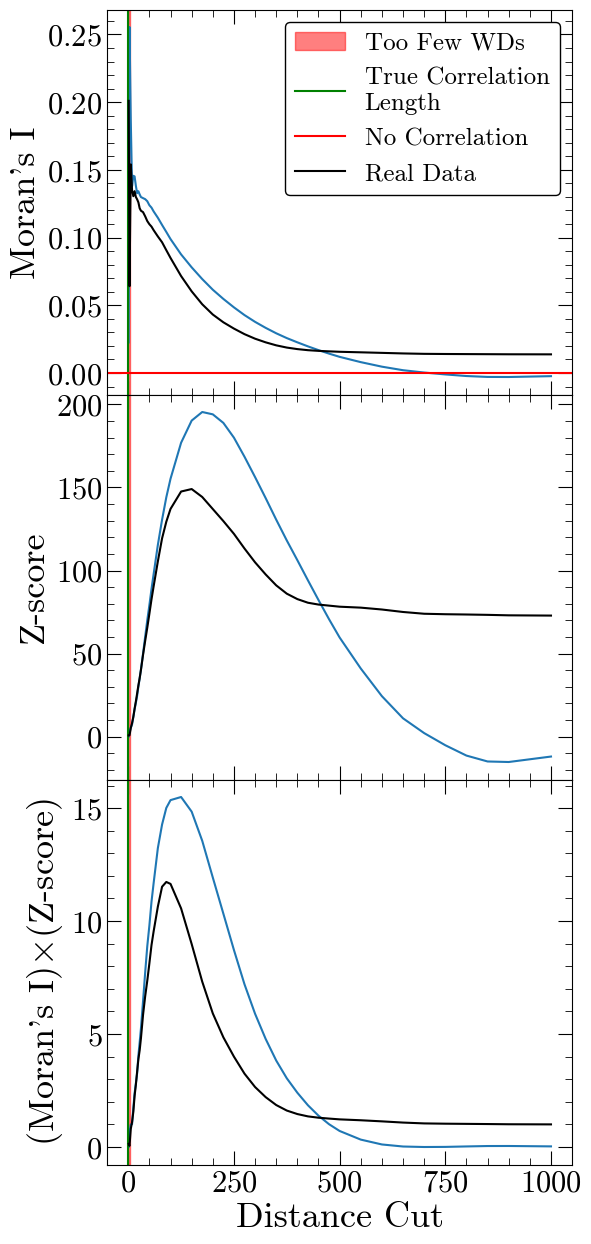

0 5 90 3 160 5


100%|█████████████████████████████████████| 10538/10538 [17:52<00:00,  9.83it/s]


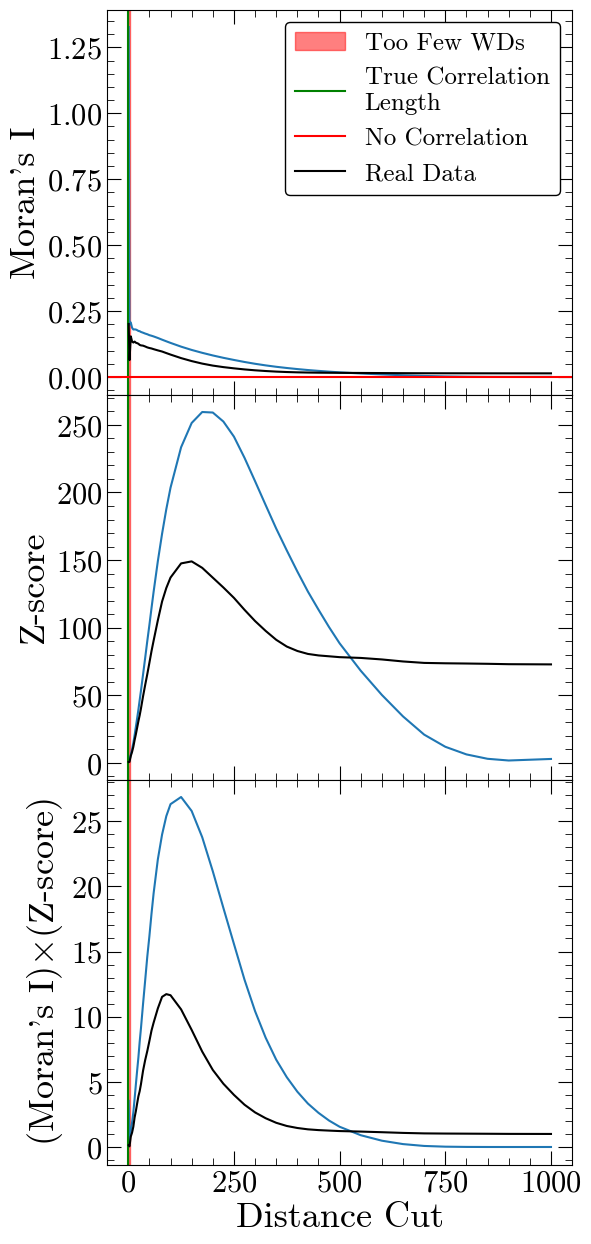

0 5 90 3 160 20


100%|█████████████████████████████████████| 10538/10538 [17:39<00:00,  9.94it/s]


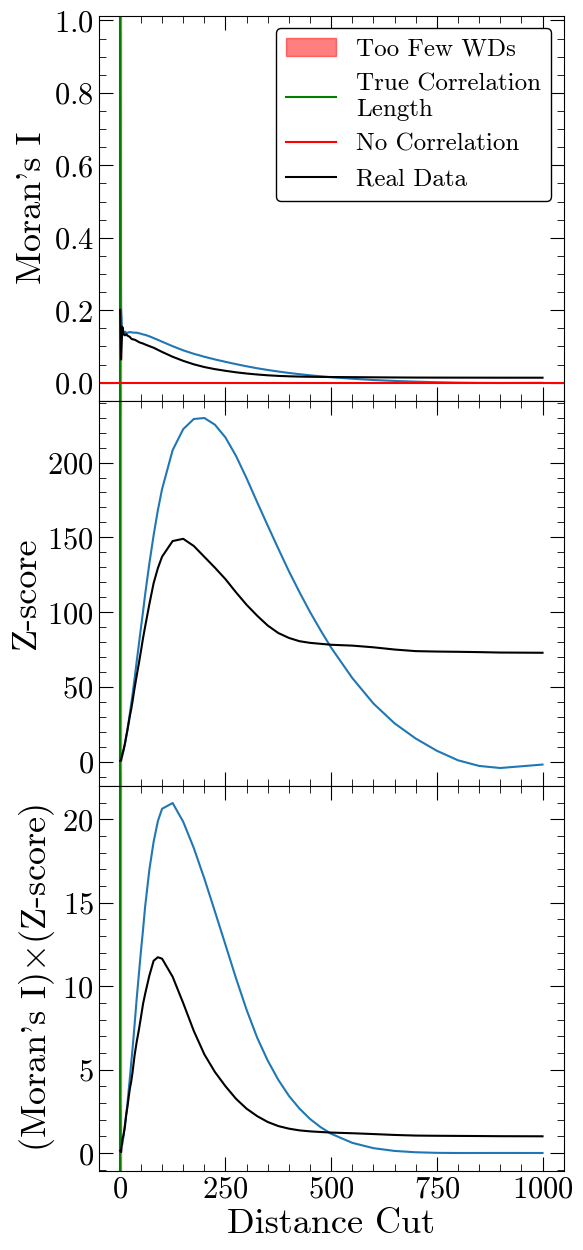

0 5 50 1 140 5


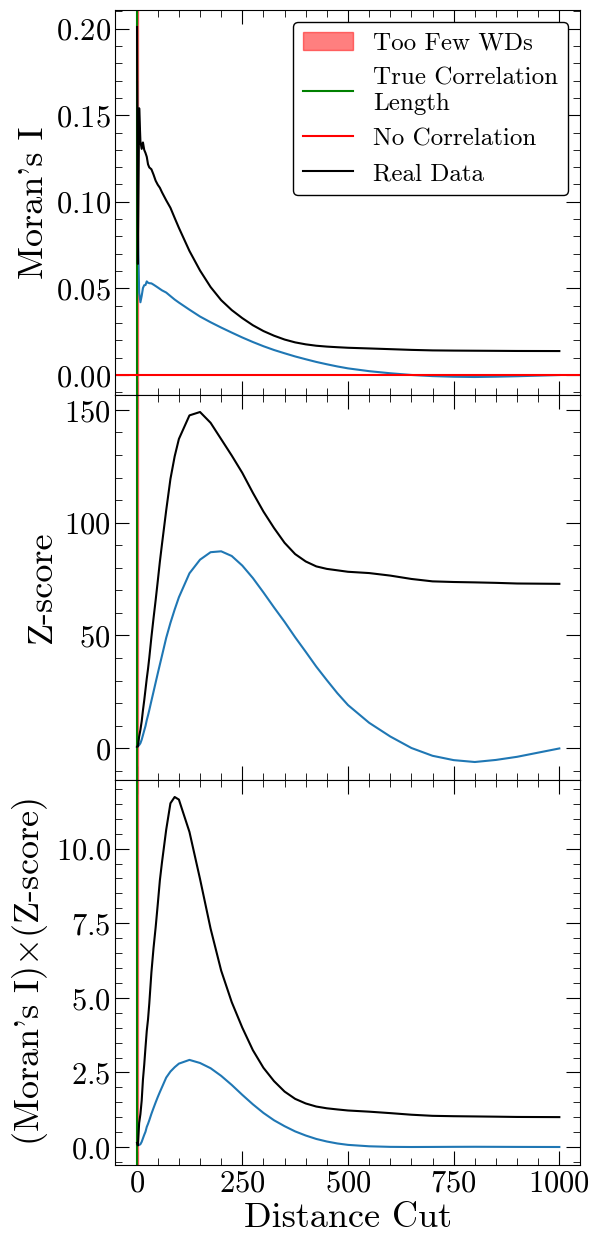

0 5 50 1 140 20


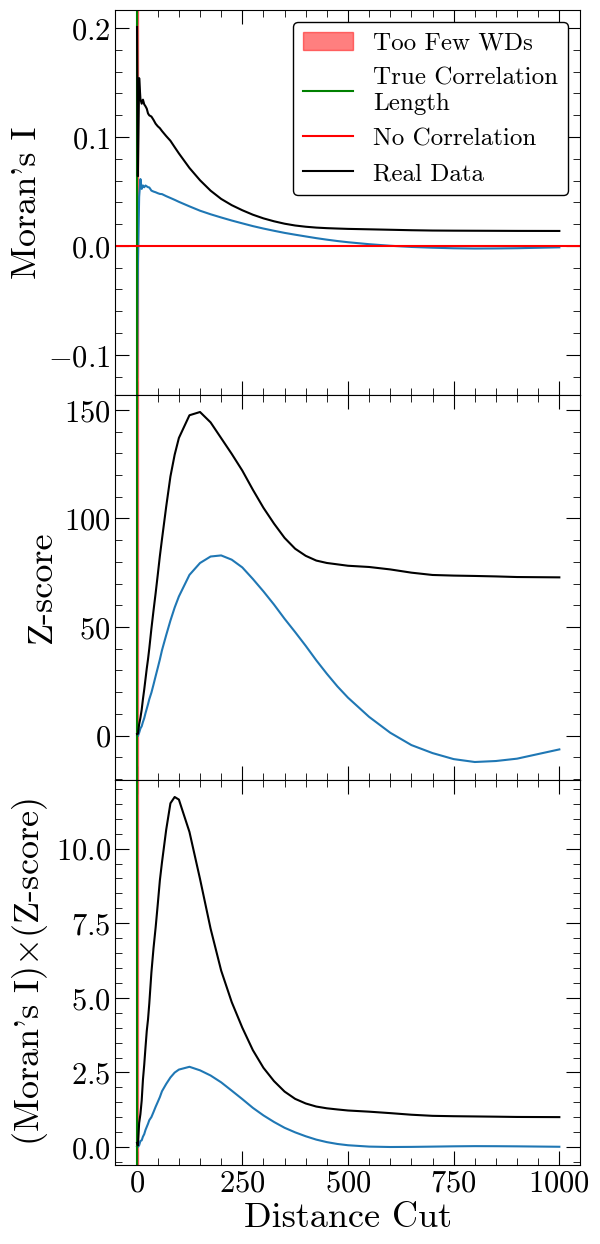

0 5 50 1 160 5


100%|█████████████████████████████████████| 10538/10538 [17:38<00:00,  9.95it/s]


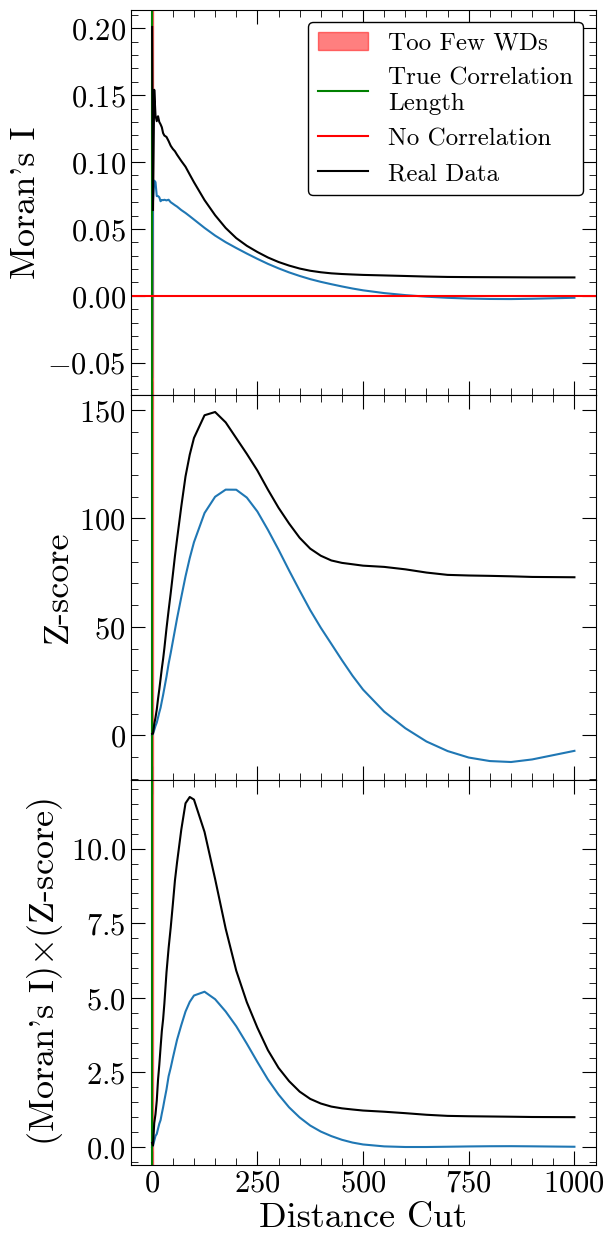

0 5 50 1 160 20


100%|█████████████████████████████████████| 10538/10538 [17:33<00:00, 10.00it/s]


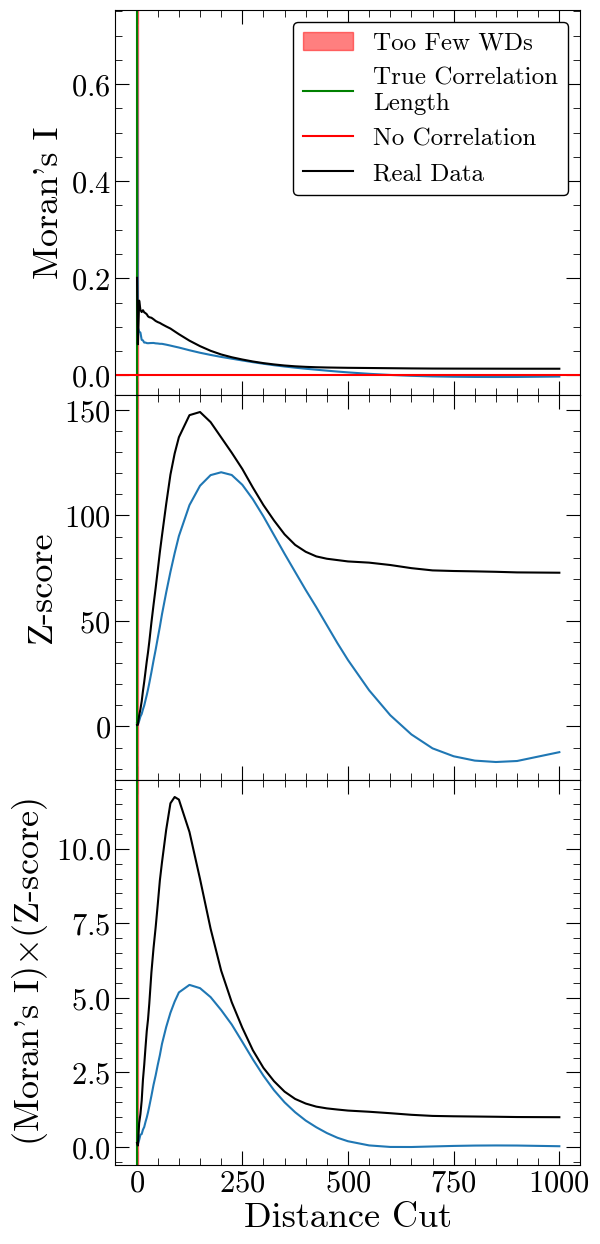

0 5 50 3 140 5


100%|█████████████████████████████████████| 10538/10538 [17:37<00:00,  9.96it/s]


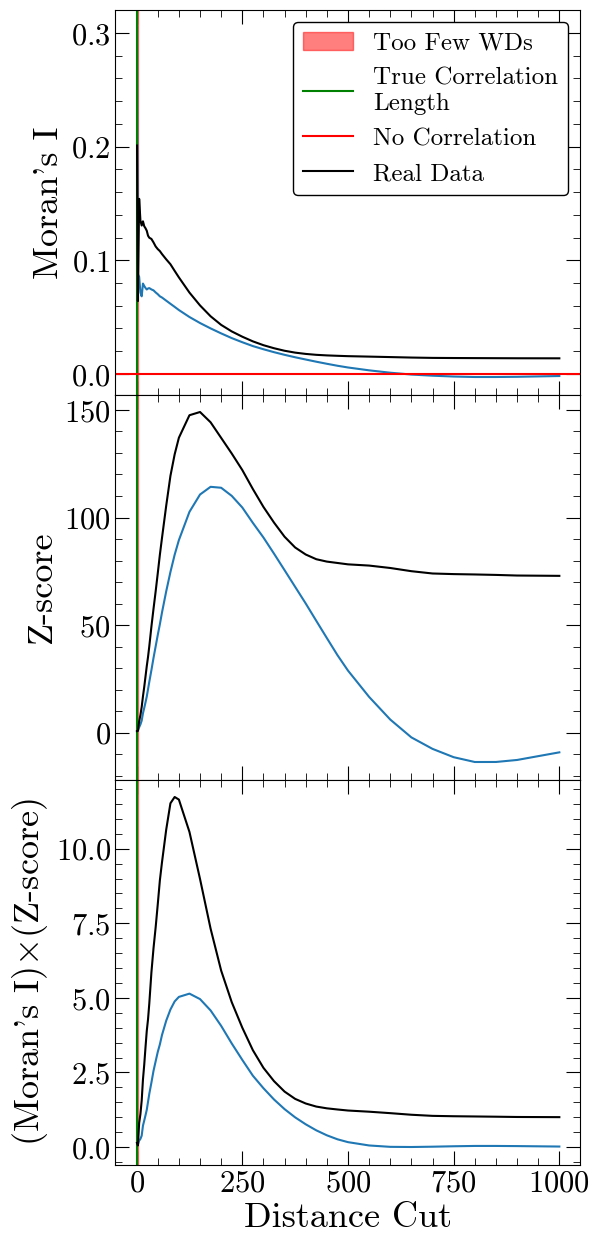

0 5 50 3 140 20


100%|█████████████████████████████████████| 10538/10538 [17:33<00:00, 10.00it/s]


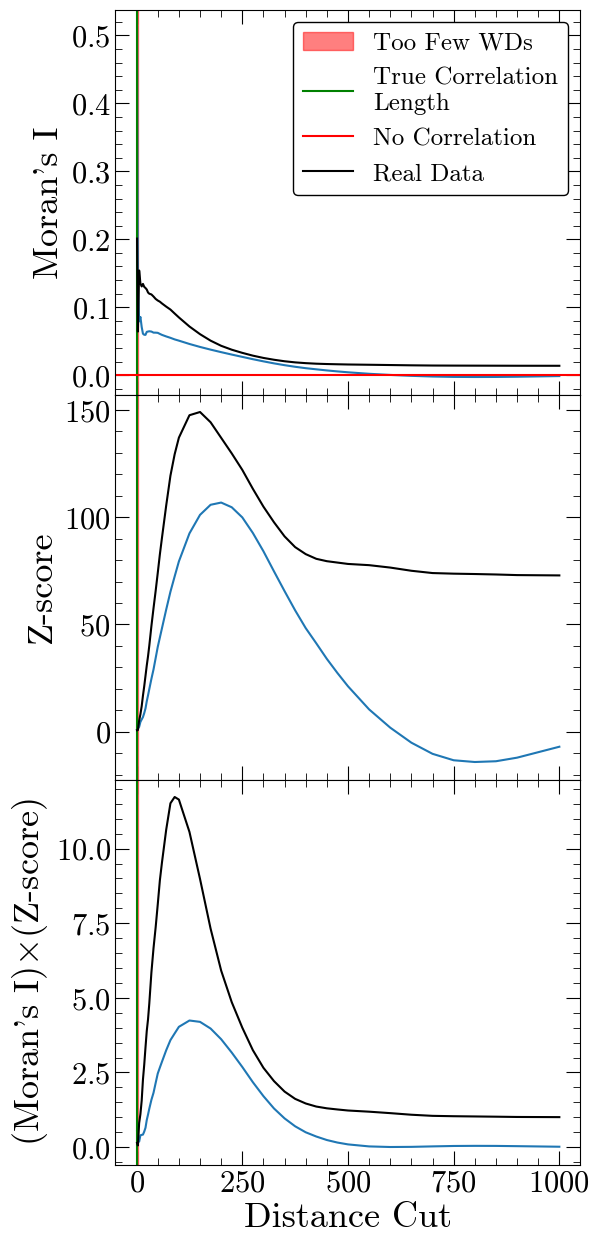

0 5 50 3 160 5


100%|█████████████████████████████████████| 10538/10538 [17:34<00:00, 10.00it/s]


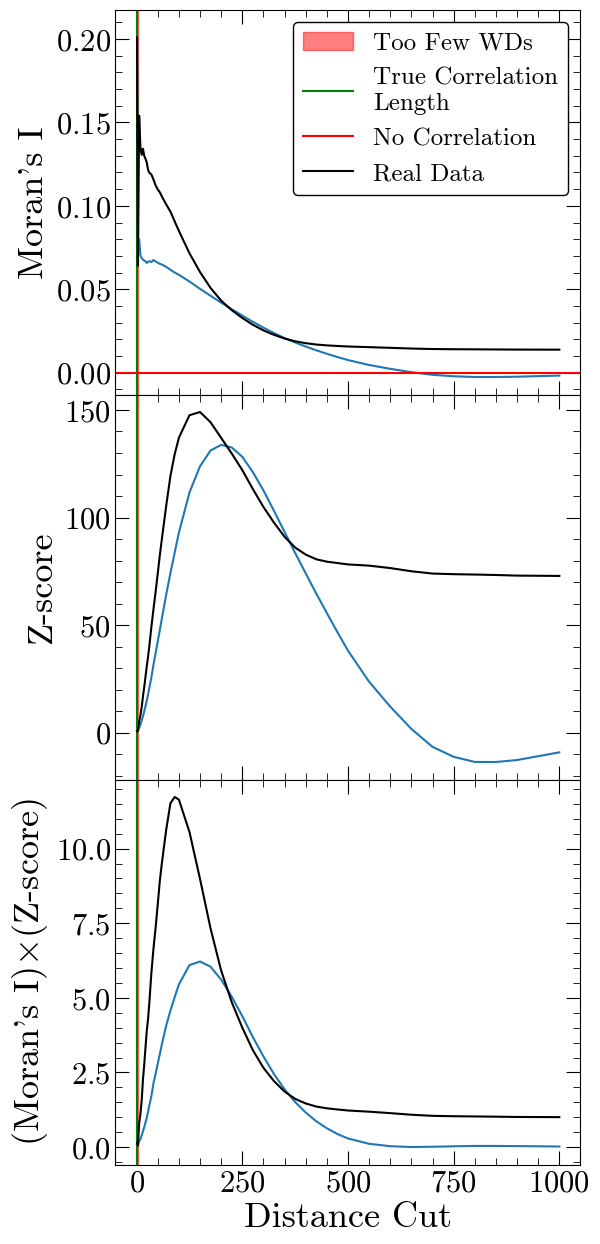

0 5 50 3 160 20


100%|█████████████████████████████████████| 10538/10538 [17:43<00:00,  9.91it/s]


KeyboardInterrupt: 

In [55]:
dist_cut_means=[140,160]
dist_cut_stds=[5,20]
unc_nears=[0,1]
unc_fars=[5,10]
off_nears=[90,50]
off_fars=[1,3]


for unc_near in unc_nears:
    for unc_far in unc_fars:
        for off_near in off_nears:
            for off_far in off_fars:
                for dist_cut_mean in dist_cut_means:
                    for dist_cut_std in dist_cut_stds:
                        print(unc_near,unc_far,off_near,off_far,dist_cut_mean,dist_cut_std)

                        full_simulation(sample_size,grid_size,distances,dist_cut_mean,dist_cut_std,unc_near,
                                        unc_far,off_near,off_far)
                        output=get_output(sample_size,dist_cut_mean,dist_cut_std,unc_near,unc_far,off_near,
                                          off_far,plot_real_data=True)

0 20 70 30 130 20


100%|█████████████████████████████████████| 10538/10538 [19:20<00:00,  9.08it/s]


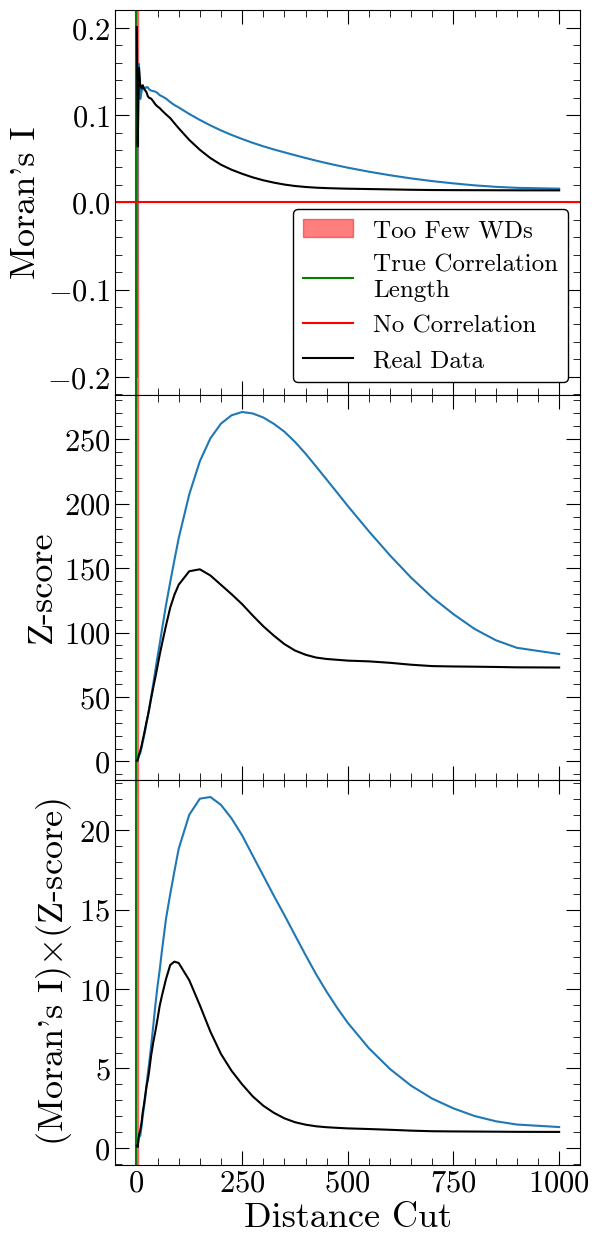

0 20 70 30 140 20


100%|█████████████████████████████████████| 10538/10538 [20:13<00:00,  8.69it/s]


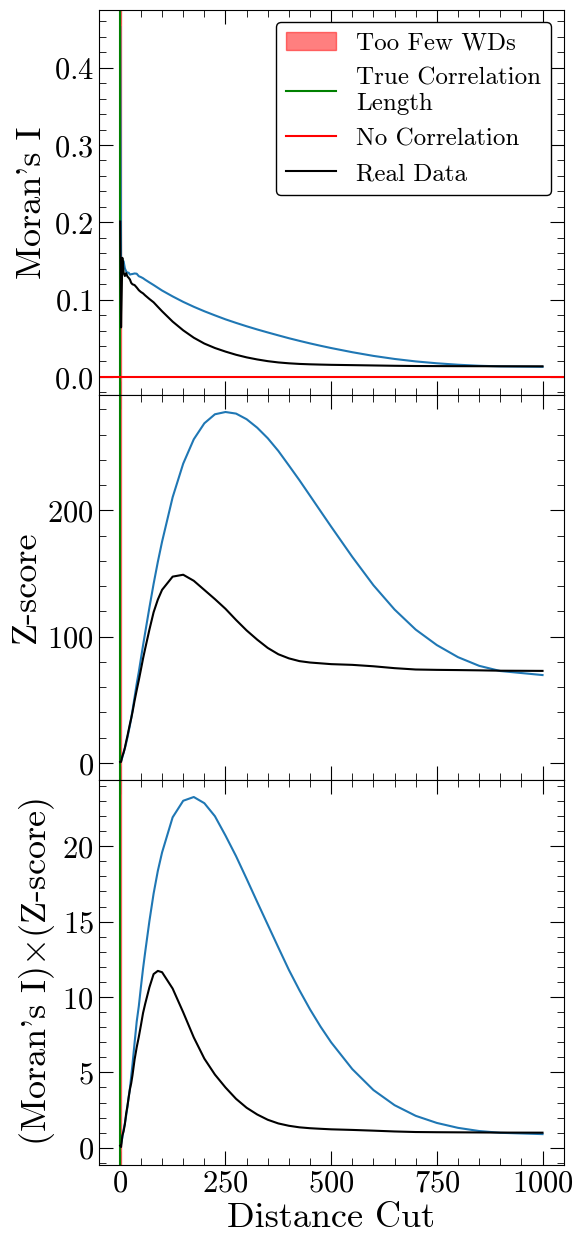

0 20 70 10 130 20


100%|█████████████████████████████████████| 10538/10538 [19:22<00:00,  9.07it/s]


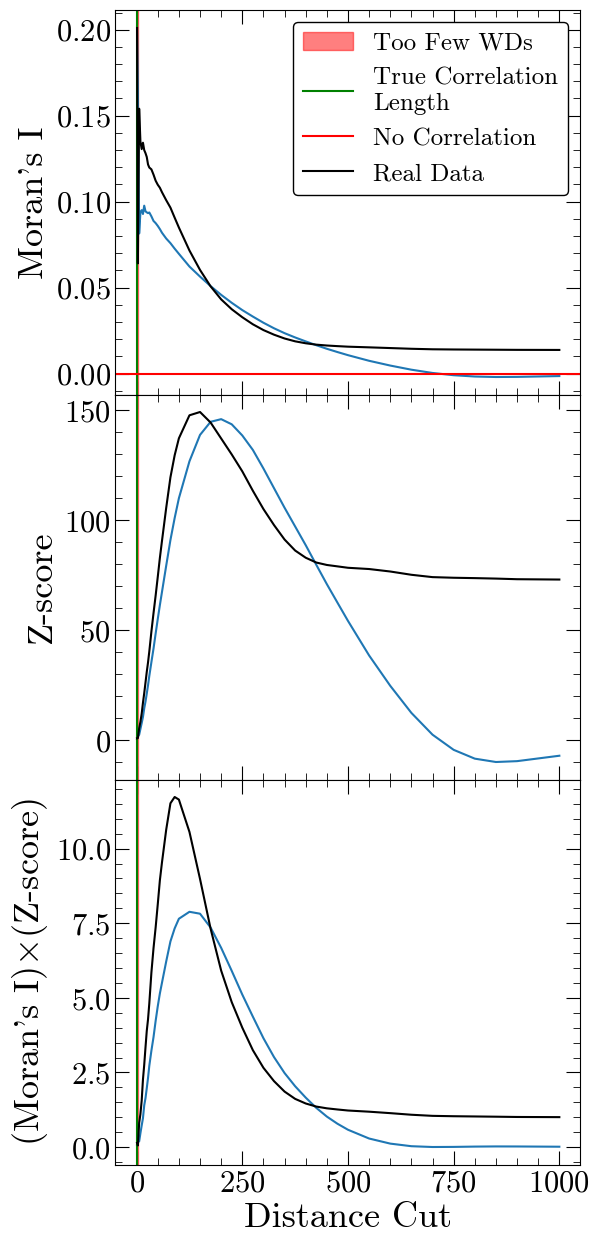

0 20 70 10 140 20


100%|█████████████████████████████████████| 10538/10538 [19:58<00:00,  8.79it/s]


KeyboardInterrupt: 

In [58]:
#best previous sims were
#0 5 90 1 140 20
#0 5 90 3 140 5
#increase far away bias but this means also have to decrease nearby bias

dist_cut_means=[130,140]
dist_cut_stds=[20]
unc_nears=[0]
unc_fars=[20,5]
off_nears=[70,90]
off_fars=[30,10]

for unc_near in unc_nears:
    for unc_far in unc_fars:
        for off_near in off_nears:
            for off_far in off_fars:
                for dist_cut_mean in dist_cut_means:
                    for dist_cut_std in dist_cut_stds:
                        print(unc_near,unc_far,off_near,off_far,dist_cut_mean,dist_cut_std)

                        full_simulation(sample_size,grid_size,distances,dist_cut_mean,dist_cut_std,unc_near,
                                        unc_far,off_near,off_far)
                        output=get_output(sample_size,dist_cut_mean,dist_cut_std,unc_near,unc_far,off_near,
                                          off_far,plot_real_data=True)

0 5 60 1 70 140 20 500


100%|█████████████████████████████████████| 10538/10538 [19:44<00:00,  8.89it/s]


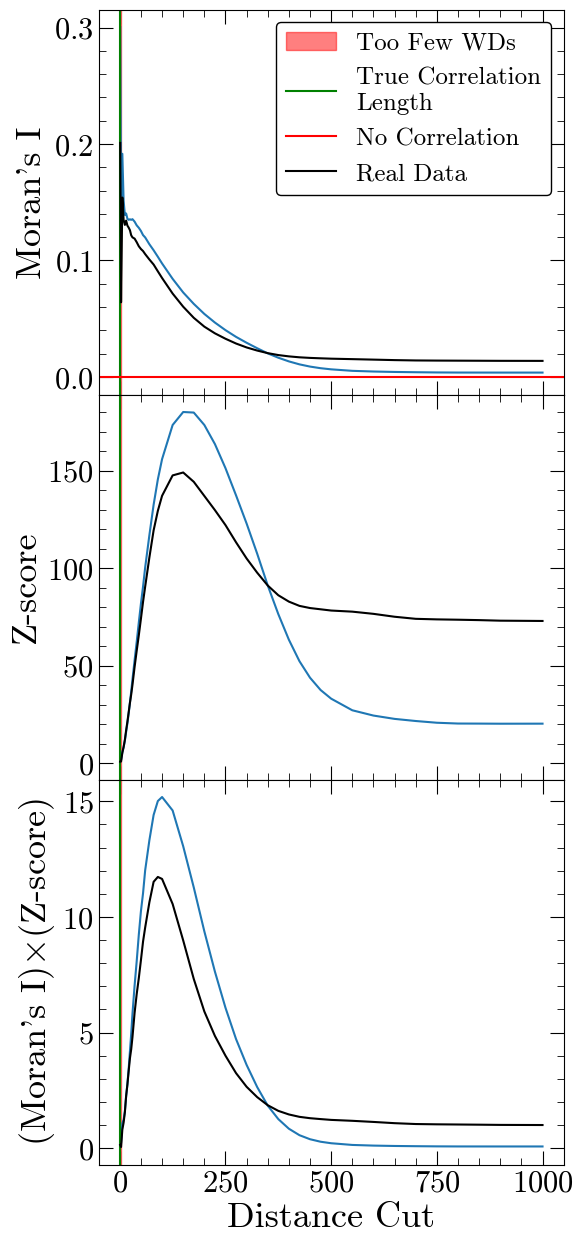

0 5 80 1 70 140 20 500


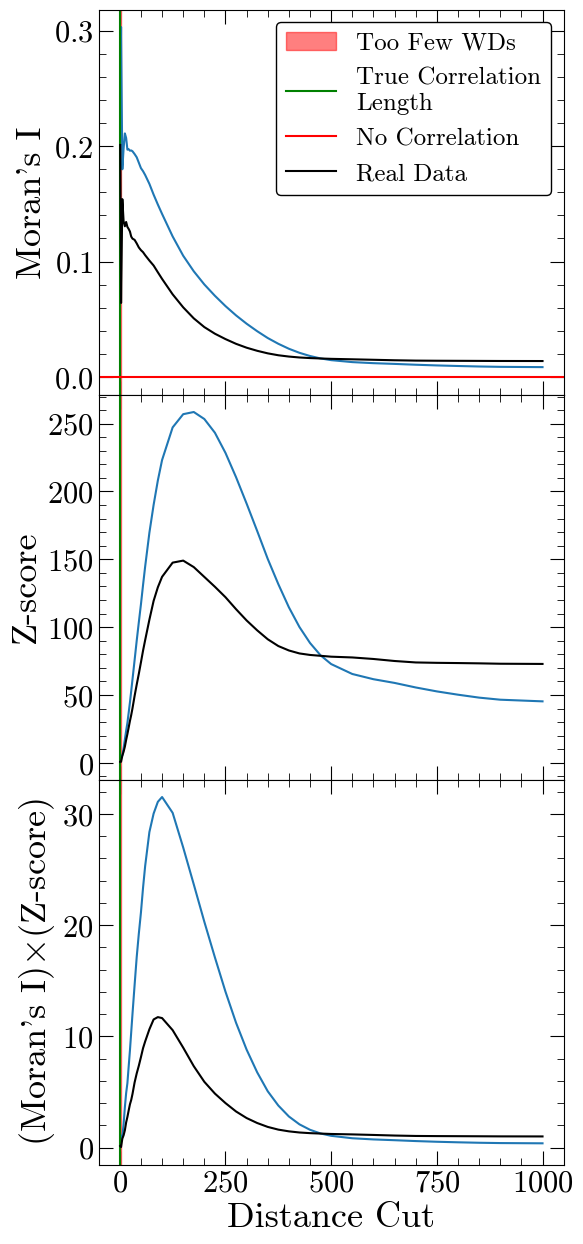

0 5 90 1 70 140 20 500


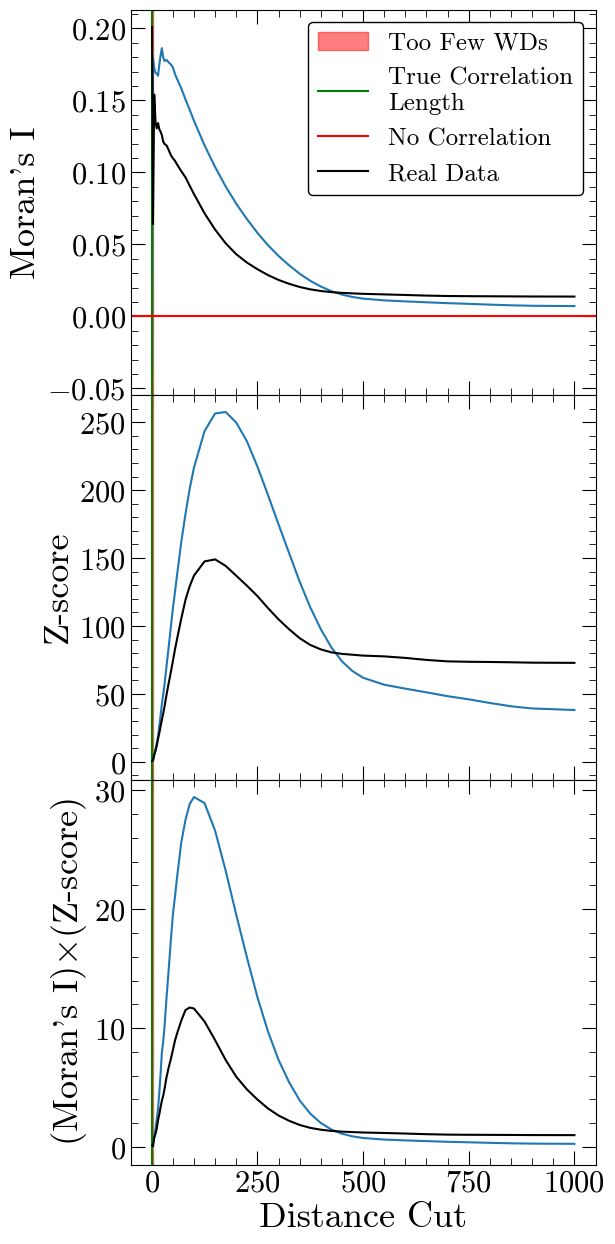

In [75]:
#best previous sims were
#0 5 90 1 140 20
#increase far away bias but this means also have to decrease nearby bias
dist_cut2=500
off_far=70

dist_cut_means=[140]
dist_cut_stds=[20]
unc_nears=[0]
unc_fars=[5]
off_nears=[60,80,90]
off_meds=[1]

for unc_near in unc_nears:
    for unc_far in unc_fars:
        for off_near in off_nears:
            for off_med in off_meds:
                for dist_cut_mean in dist_cut_means:
                    for dist_cut_std in dist_cut_stds:
                        print(unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2)

                        full_simulation(sample_size,grid_size,distances,dist_cut_mean,dist_cut_std,dist_cut2,
                                        unc_near,unc_far,off_near,off_med,off_far)
                        output=get_output(sample_size,dist_cut_mean,dist_cut_std,dist_cut2,
                                        unc_near,unc_far,off_near,off_med,off_far,plot_real_data=True)

In [18]:
#best previous sims were
#0 5 90 1 140 20
#increase far away bias but this means also have to decrease nearby bias

dist_cut_means=[120,140,160]
dist_cut_stds=[5,20,40]
dist_cut2s=[400,500,600]
unc_nears=[1,5,10]
unc_fars=[1,5,10,30]
off_nears=[90,70,50]
off_meds=[0,5,20]
off_fars=[90,70,50]

for unc_near in unc_nears:
    for unc_far in unc_fars:
        for off_near in off_nears:
            for off_med in off_meds:
                for off_far in off_fars:
                    for dist_cut_mean in dist_cut_means:
                        for dist_cut_std in dist_cut_stds:
                            for dist_cut2 in dist_cut2s:
                                print(unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2)

                                full_simulation(sample_size,grid_size,distances,dist_cut_mean,dist_cut_std,dist_cut2,
                                                unc_near,unc_far,off_near,off_med,off_far)
    #                             output=get_output(sample_size,dist_cut_mean,dist_cut_std,dist_cut2,
    #                                             unc_near,unc_far,off_near,off_med,off_far,plot_real_data=True)

1 1 90 0 90 120 5 400
1 1 90 0 90 120 5 500
1 1 90 0 90 120 5 600
1 1 90 0 90 120 20 400
1 1 90 0 90 120 20 500
1 1 90 0 90 120 20 600
1 1 90 0 90 120 40 400
1 1 90 0 90 120 40 500
1 1 90 0 90 120 40 600
1 1 90 0 90 140 5 400
1 1 90 0 90 140 5 500
1 1 90 0 90 140 5 600
1 1 90 0 90 140 20 400
1 1 90 0 90 140 20 500
1 1 90 0 90 140 20 600
1 1 90 0 90 140 40 400
1 1 90 0 90 140 40 500
1 1 90 0 90 140 40 600
1 1 90 0 90 160 5 400
1 1 90 0 90 160 5 500
1 1 90 0 90 160 5 600
1 1 90 0 90 160 20 400
1 1 90 0 90 160 20 500
1 1 90 0 90 160 20 600
1 1 90 0 90 160 40 400
1 1 90 0 90 160 40 500
1 1 90 0 90 160 40 600
1 1 90 0 70 120 5 400
1 1 90 0 70 120 5 500
1 1 90 0 70 120 5 600
1 1 90 0 70 120 20 400
1 1 90 0 70 120 20 500
1 1 90 0 70 120 20 600
1 1 90 0 70 120 40 400
1 1 90 0 70 120 40 500
1 1 90 0 70 120 40 600
1 1 90 0 70 140 5 400
1 1 90 0 70 140 5 500
1 1 90 0 70 140 5 600
1 1 90 0 70 140 20 400
1 1 90 0 70 140 20 500
1 1 90 0 70 140 20 600
1 1 90 0 70 140 40 400
1 1 90 0 70 140 40 500
1 1

KeyboardInterrupt: 

8748


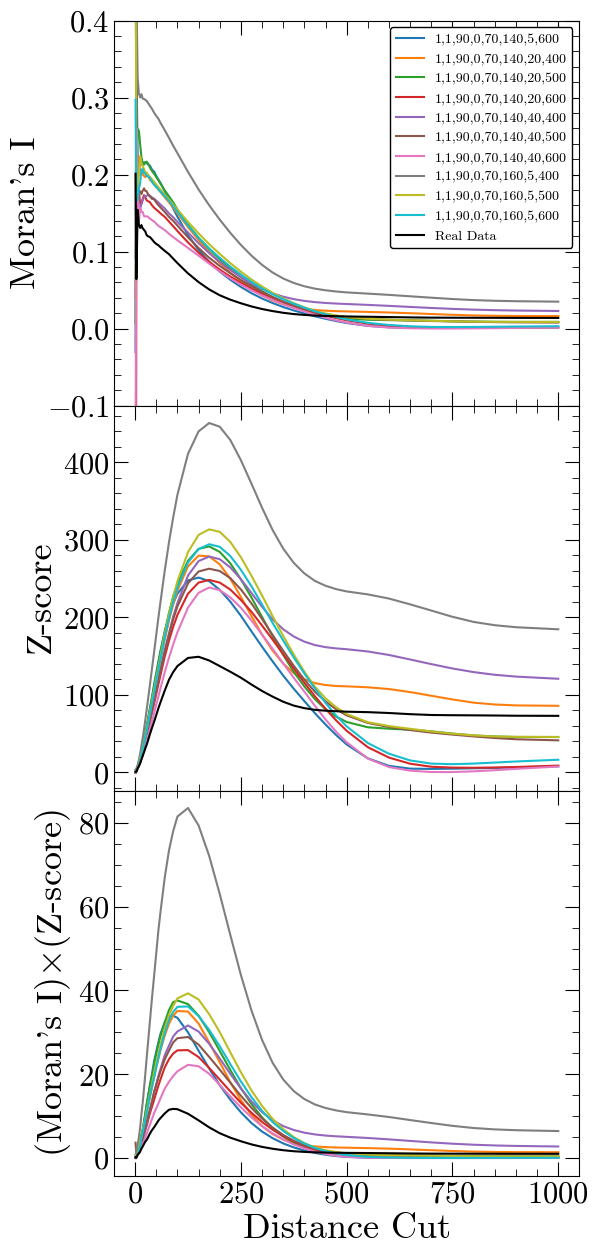

In [31]:
simulations=[]
for unc_near in unc_nears:
    for unc_far in unc_fars:
        for off_near in off_nears:
            for off_med in off_meds:
                for off_far in off_fars:
                    for dist_cut_mean in dist_cut_means:
                        for dist_cut_std in dist_cut_stds:
                            for dist_cut2 in dist_cut2s:
                                sim=[unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2]
                                simulations.append(sim)

print(len(simulations))

i=38
sims_short=simulations[i:i+10]

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
for sim in sims_short:
    unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2=sim
    final_distances,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(sample_size,dist_cut_mean,dist_cut_std,dist_cut2,unc_near,unc_far,off_near,off_med,off_far,plot=False)
    
    #plot each simulation
    ax1.plot(final_distances,moransIs, label=str(unc_near)+','+str(unc_far)+','+str(off_near)+','+str(off_med)+','+str(off_far)+','+str(dist_cut_mean)+','+str(dist_cut_std)+','+str(dist_cut2))
    ax2.plot(final_distances,zscores)
    ax3.plot(final_distances,mult)

#plot extinction-corrected real data
file_path='csv/nb06_sample_size_'+str(sample_size)
npzfile = np.load(file_path+'/data_measurement.npz')
med_abs_deviations = npzfile['med_abs_deviations']
Ws = npzfile['Ws']
final_distances = npzfile['distances']
moransIs = npzfile['moransIs'] 
expectations = npzfile['expectations']
variances = npzfile['variances']
zscores = npzfile['zscores']
mult=[]
for i in range(len(moransIs)):
    mult.append(moransIs[i]*zscores[i])
ax1.plot(final_distances,moransIs,color='black',label='Real Data')
ax2.plot(final_distances,zscores,color='black')
ax3.plot(final_distances,mult,color='black')

ax1.set_ylabel("Moran's I")
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
ax1.legend(fontsize=10)

ax1.set_ylim(-0.1,0.4)
plt.subplots_adjust(wspace = 0,hspace=0)
